# 🛌 Sleep Staging Visualization & Evaluation

This notebook provides comprehensive visualization and statistical evaluation of sleep staging predictions.

**Sleep Stages:**
- `0` → Wake
- `1` → N1 (NREM Stage 1)
- `2` → N2 (NREM Stage 2)
- `3` → N3 (NREM Stage 3 / Slow-Wave Sleep)
- `4` → REM

---

In [1]:
# ─── Imports ──────────────────────────────────────────────────────────────────
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    cohen_kappa_score, confusion_matrix, classification_report,
    roc_auc_score
)
from scipy.special import softmax

print('✅ All libraries imported successfully.')

✅ All libraries imported successfully.


In [2]:
# ─── Configuration ────────────────────────────────────────────────────────────

# Path to the sleep staging CSV results folder
RESULTS_DIR = os.path.join(os.path.dirname(os.getcwd()), 'results', 'sleep_staging')
# If running the notebook from the same directory as results/, adjust accordingly:
if not os.path.isdir(RESULTS_DIR):
    RESULTS_DIR = 'sleep_staging'  # fallback for notebook-local run
if not os.path.isdir(RESULTS_DIR):
    # Try relative to notebook location
    RESULTS_DIR = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'sleep_staging')

EPOCH_SEC = 30          # Seconds per epoch (standard 30-second PSG epoch)
STAGE_NAMES = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
STAGE_COLORS = {
    'Wake': '#E74C3C',
    'N1':   '#F39C12',
    'N2':   '#3498DB',
    'N3':   '#2ECC71',
    'REM':  '#9B59B6',
}
STAGE_ORDER = ['Wake', 'N1', 'N2', 'N3', 'REM']

# Probability columns → stage labels
PROB_COLS = ['prob_Wake', 'prob_N1', 'prob_N2', 'prob_N3', 'prob_REM']

# Matplotlib style
plt.rcParams.update({
    'figure.facecolor': '#0F1117',
    'axes.facecolor':   '#1A1D27',
    'axes.edgecolor':   '#3A3D4D',
    'axes.labelcolor':  '#E0E0E0',
    'xtick.color':      '#A0A0B0',
    'ytick.color':      '#A0A0B0',
    'text.color':       '#E0E0E0',
    'grid.color':       '#2D3040',
    'grid.linestyle':   '--',
    'grid.alpha':       0.6,
    'font.family':      'DejaVu Sans',
    'font.size':        11,
    'axes.titlesize':   13,
    'axes.titleweight': 'bold',
    'legend.facecolor': '#1E2130',
    'legend.edgecolor': '#3A3D4D',
})

print(f'📁 Results directory : {RESULTS_DIR}')
csv_files = sorted(glob.glob(os.path.join(RESULTS_DIR, '*.csv')))
print(f'📄 CSV files found   : {len(csv_files)}')

📁 Results directory : /home/nummm/Documents/CEPP/sleepfm-clinical/custom/results/sleep_staging
📄 CSV files found   : 22


In [3]:
# ─── Load All Data ────────────────────────────────────────────────────────────

def load_dataframes(csv_files):
    """Load all CSV result files and tag each row with subject ID."""
    dfs = []
    for fp in csv_files:
        df = pd.read_csv(fp)
        df['subject_id'] = os.path.basename(fp).replace('.csv', '')
        df['epoch_idx']  = range(len(df))
        df['time_min']   = df['epoch_idx'] * EPOCH_SEC / 60
        # Map integer stage codes → names
        df['pred_name'] = df['predicted_stage'].map(STAGE_NAMES)
        df['true_name'] = df['true_stage'].map(STAGE_NAMES)
        dfs.append(df)
    return dfs

all_dfs = load_dataframes(csv_files)
combined_df = pd.concat(all_dfs, ignore_index=True)

print(f'Total epochs loaded  : {len(combined_df):,}')
print(f'Stages present (true): {sorted(combined_df["true_stage"].unique())}')
print(f'\nClass distribution (true):')
for k, v in combined_df['true_stage'].value_counts().sort_index().items():
    print(f'  Stage {STAGE_NAMES[k]:>4s}: {v:6,} epochs  ({100*v/len(combined_df):.1f}%)')

Total epochs loaded  : 105,426
Stages present (true): [0, 1, 2, 3, 4]

Class distribution (true):
  Stage Wake: 15,504 epochs  (14.7%)
  Stage   N1:  9,012 epochs  (8.5%)
  Stage   N2: 44,538 epochs  (42.2%)
  Stage   N3: 19,242 epochs  (18.3%)
  Stage  REM: 17,130 epochs  (16.2%)


---
## 1. Global Performance Metrics (All Subjects)

In [4]:
# ─── Global Metrics ───────────────────────────────────────────────────────────

y_true = combined_df['true_stage'].values
y_pred = combined_df['predicted_stage'].values

present_stages = sorted(combined_df['true_stage'].unique())
target_names   = [STAGE_NAMES[s] for s in present_stages]

acc      = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro',    labels=present_stages, zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', labels=present_stages, zero_division=0)
kappa    = cohen_kappa_score(y_true, y_pred)
prec     = precision_score(y_true, y_pred, average='macro', labels=present_stages, zero_division=0)
rec      = recall_score(y_true, y_pred, average='macro',    labels=present_stages, zero_division=0)

print('=' * 50)
print('  📊  GLOBAL PERFORMANCE METRICS')
print('=' * 50)
print(f'  Accuracy          : {acc:.4f}  ({acc*100:.2f}%)')
print(f'  Macro F1          : {f1_macro:.4f}')
print(f'  Weighted F1       : {f1_weighted:.4f}')
print(f'  Macro Precision   : {prec:.4f}')
print(f'  Macro Recall      : {rec:.4f}')
print(f'  Cohen Kappa (κ)   : {kappa:.4f}')
print('=' * 50)
print('  Per-Class Report:')
print(classification_report(y_true, y_pred, labels=present_stages,
                             target_names=target_names, zero_division=0))

  📊  GLOBAL PERFORMANCE METRICS
  Accuracy          : 0.6806  (68.06%)
  Macro F1          : 0.6375
  Weighted F1       : 0.6713
  Macro Precision   : 0.7250
  Macro Recall      : 0.6461
  Cohen Kappa (κ)   : 0.5563
  Per-Class Report:
              precision    recall  f1-score   support

        Wake       0.71      0.86      0.78     15504
          N1       0.35      0.58      0.44      9012
          N2       0.67      0.80      0.73     44538
          N3       0.99      0.30      0.46     19242
         REM       0.90      0.70      0.79     17130

    accuracy                           0.68    105426
   macro avg       0.73      0.65      0.64    105426
weighted avg       0.75      0.68      0.67    105426



---
## 2. Confusion Matrix

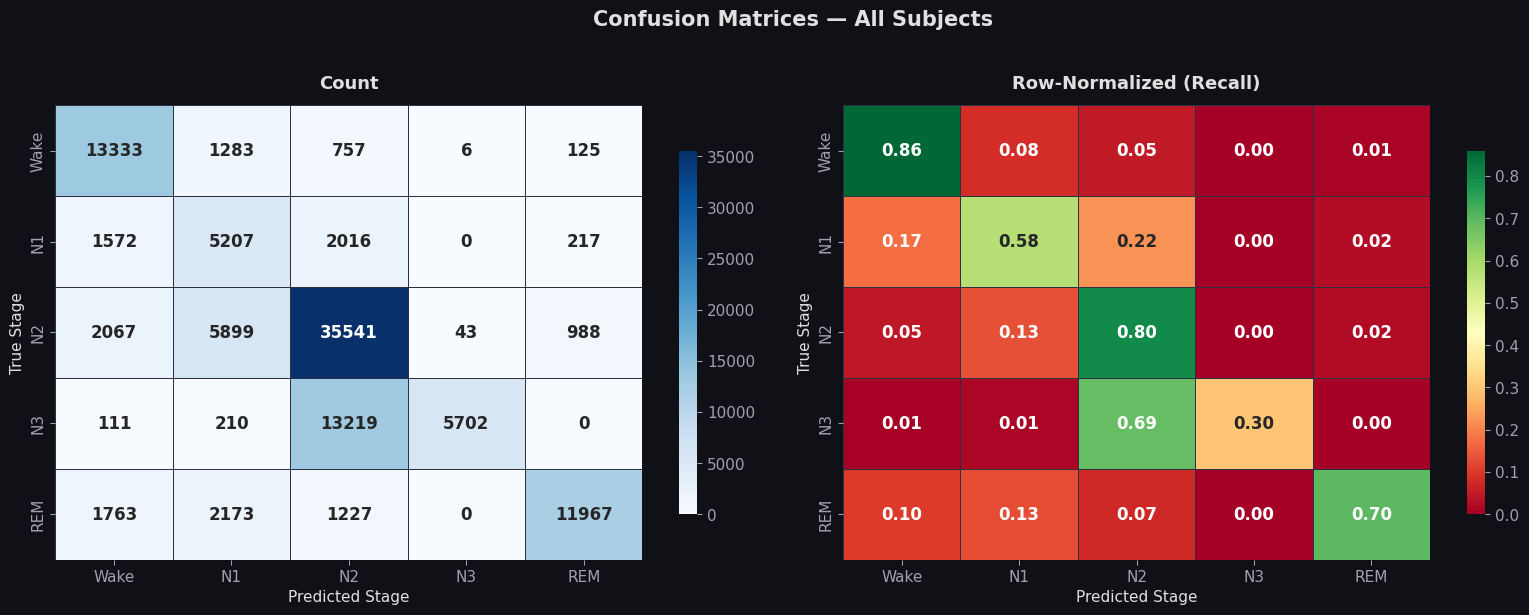

💾 Saved: confusion_matrix.png


In [5]:
# ─── Confusion Matrix (Count + Normalized) ────────────────────────────────────

cm       = confusion_matrix(y_true, y_pred, labels=present_stages)
cm_norm  = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # row-normalized

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Confusion Matrices — All Subjects', fontsize=15, fontweight='bold', y=1.02)

for ax, data, fmt, title in [
    (axes[0], cm,      'd',    'Count'),
    (axes[1], cm_norm, '.2f',  'Row-Normalized (Recall)'),
]:
    cmap = sns.color_palette('Blues', as_cmap=True) if fmt == 'd' else sns.color_palette('RdYlGn', as_cmap=True)
    sns.heatmap(
        data, ax=ax, annot=True, fmt=fmt, cmap=cmap,
        xticklabels=target_names, yticklabels=target_names,
        linewidths=0.5, linecolor='#2D3040',
        cbar_kws={'shrink': 0.8},
        annot_kws={'size': 12, 'weight': 'bold'}
    )
    ax.set_title(title, pad=12)
    ax.set_xlabel('Predicted Stage')
    ax.set_ylabel('True Stage')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: confusion_matrix.png')

---
## 3. Per-Stage F1, Precision, Recall Bar Chart

Stage  Precision  Recall  F1-Score  Support
 Wake     0.7075  0.8600    0.7763    15504
   N1     0.3525  0.5778    0.4379     9012
   N2     0.6736  0.7980    0.7306    44538
   N3     0.9915  0.2963    0.4563    19242
  REM     0.9000  0.6986    0.7866    17130


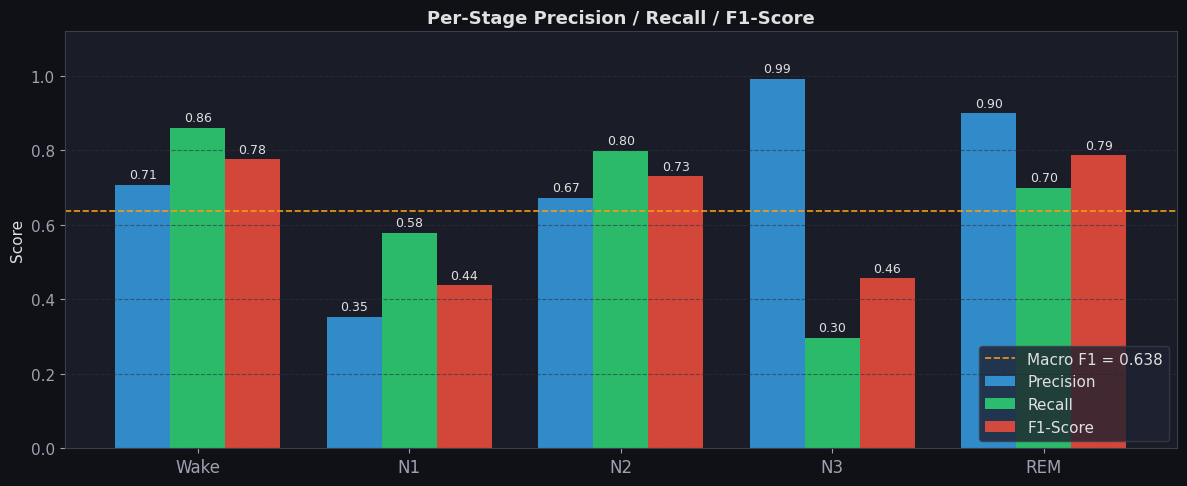

💾 Saved: per_stage_metrics.png


In [6]:
# ─── Per-Stage Metrics ────────────────────────────────────────────────────────

from sklearn.metrics import precision_recall_fscore_support

prec_per, rec_per, f1_per, sup_per = precision_recall_fscore_support(
    y_true, y_pred, labels=present_stages, zero_division=0
)

metrics_df = pd.DataFrame({
    'Stage':     target_names,
    'Precision': prec_per,
    'Recall':    rec_per,
    'F1-Score':  f1_per,
    'Support':   sup_per,
})
print(metrics_df.to_string(index=False, float_format='{:.4f}'.format))

# Grouped bar chart
x     = np.arange(len(target_names))
width = 0.26

fig, ax = plt.subplots(figsize=(12, 5))
bars = [
    ax.bar(x - width, prec_per, width, label='Precision', color='#3498DB', alpha=0.9),
    ax.bar(x,         rec_per,  width, label='Recall',    color='#2ECC71', alpha=0.9),
    ax.bar(x + width, f1_per,   width, label='F1-Score',  color='#E74C3C', alpha=0.9),
]

# Value labels on top of bars
for bar_group in bars:
    for bar in bar_group:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.2f}',
                ha='center', va='bottom', fontsize=9, color='#E0E0E0')

ax.set_xticks(x)
ax.set_xticklabels(target_names, fontsize=12)
ax.set_ylim(0, 1.12)
ax.set_ylabel('Score')
ax.set_title('Per-Stage Precision / Recall / F1-Score')
ax.legend(loc='lower right')
ax.grid(axis='y')
ax.axhline(f1_macro, color='#F39C12', linestyle='--', linewidth=1.2, label=f'Macro F1 = {f1_macro:.3f}')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('per_stage_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: per_stage_metrics.png')

---
## 4. Hypnogram — Single Subject (True vs Predicted)

💾 Saved: hypnogram_00000399-159547.png


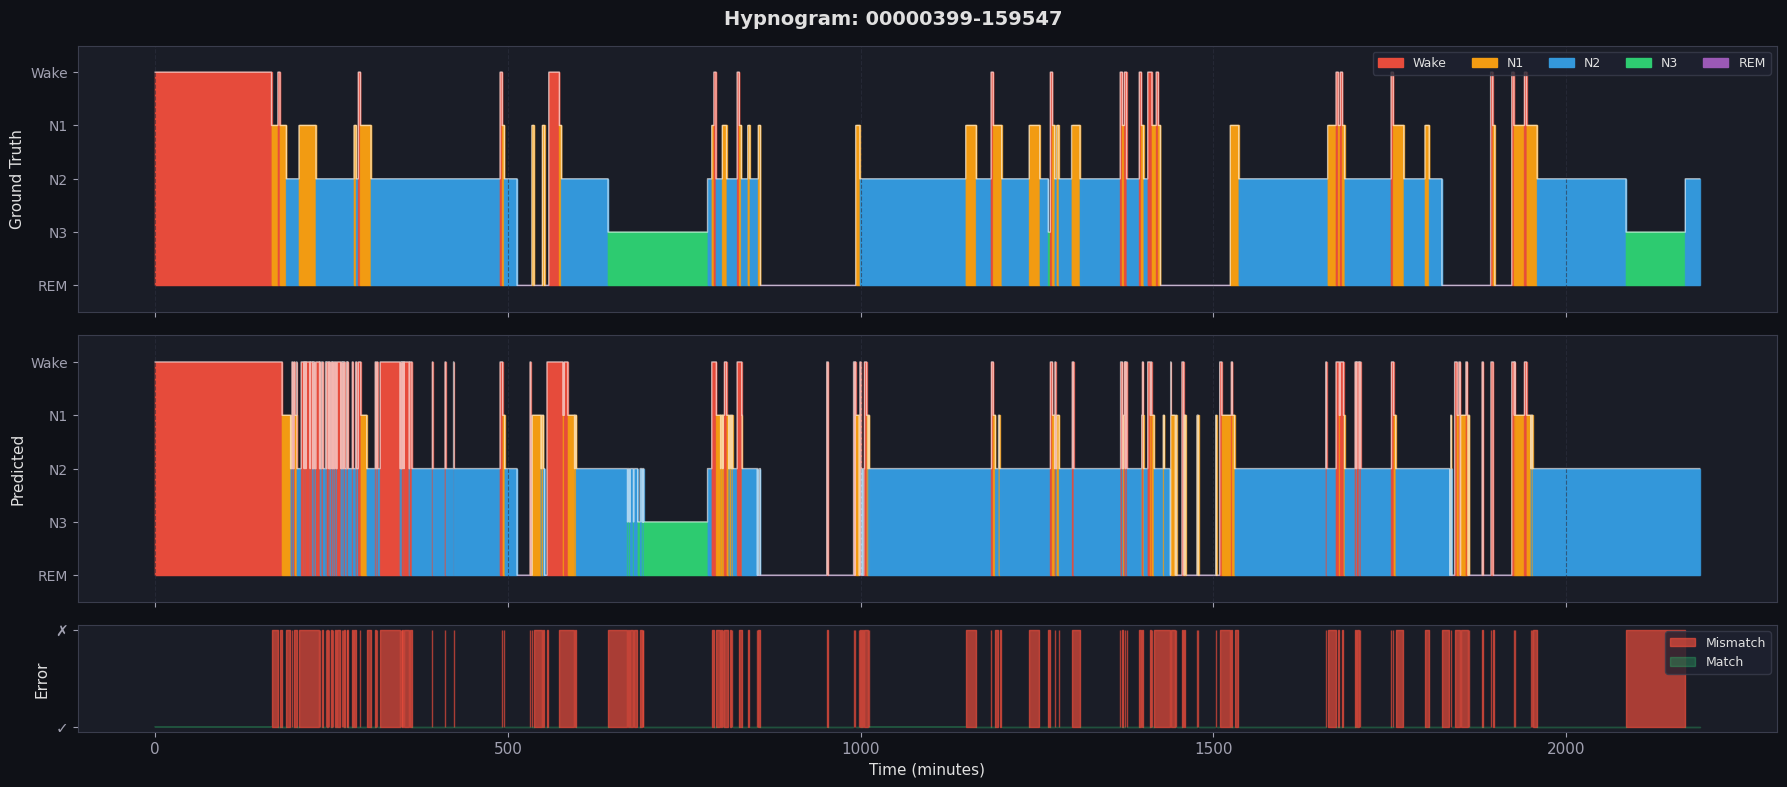

In [7]:
# ─── Hypnogram for One Subject ────────────────────────────────────────────────

def plot_hypnogram(df, subject_id, ax_true=None, ax_pred=None, ax_diff=None, save=True):
    """Plot hypnogram with difference indicator for a single subject."""
    stage_y = {0: 4, 1: 3, 2: 2, 3: 1, 4: 0}  # Invert: REM at bottom, Wake at top
    stage_labels = {4: 'Wake', 3: 'N1', 2: 'N2', 1: 'N3', 0: 'REM'}
    colors_map  = {4: '#E74C3C', 3: '#F39C12', 2: '#3498DB', 1: '#2ECC71', 0: '#9B59B6'}

    if ax_true is None:
        fig, (ax_true, ax_pred, ax_diff) = plt.subplots(
            3, 1, figsize=(18, 8), sharex=True,
            gridspec_kw={'height_ratios': [2, 2, 0.8]}
        )
        fig.suptitle(f'Hypnogram: {subject_id}', fontsize=14, fontweight='bold')
        created_fig = True
    else:
        created_fig = False

    t = df['time_min'].values

    for ax, col, label in [(ax_true, 'true_stage', 'Ground Truth'), (ax_pred, 'predicted_stage', 'Predicted')]:
        stages = df[col].values
        for i in range(len(stages) - 1):
            s = stages[i]
            ax.fill_between(
                [t[i], t[i+1]], [stage_y[s]] * 2, alpha=0.8,
                color=colors_map[stage_y[s]], step='post'
            )
        ax.step(t, [stage_y[s] for s in stages], where='post',
                color='white', linewidth=1.0, alpha=0.6)
        ax.set_yticks(list(stage_labels.keys()))
        ax.set_yticklabels(list(stage_labels.values()), fontsize=10)
        ax.set_ylabel(label)
        ax.set_ylim(-0.5, 4.5)
        ax.grid(axis='x')

    # Difference row
    wrong = (df['true_stage'].values != df['predicted_stage'].values).astype(float)
    ax_diff.fill_between(t, wrong, 0, where=wrong > 0,
                         color='#E74C3C', alpha=0.7, step='post', label='Mismatch')
    ax_diff.fill_between(t, wrong, 0, where=wrong == 0,
                         color='#2ECC71', alpha=0.3, step='post', label='Match')
    ax_diff.set_yticks([0, 1])
    ax_diff.set_yticklabels(['✓', '✗'], fontsize=11)
    ax_diff.set_ylabel('Error')
    ax_diff.set_xlabel('Time (minutes)')
    ax_diff.legend(loc='upper right', fontsize=9)

    # Color legend patches
    patches = [mpatches.Patch(color=colors_map[stage_y[k]], label=STAGE_NAMES[k])
               for k in present_stages]
    ax_true.legend(handles=patches, loc='upper right', ncol=len(patches), fontsize=9)

    if created_fig:
        plt.tight_layout()
        if save:
            fname = f'hypnogram_{subject_id}.png'
            plt.savefig(fname, dpi=150, bbox_inches='tight')
            print(f'💾 Saved: {fname}')
        plt.show()

# ── Plot first subject
example_df = all_dfs[0]
example_id = example_df['subject_id'].iloc[0]
plot_hypnogram(example_df, example_id)

---
## 5. Probability Heatmap Over Time (Single Subject)

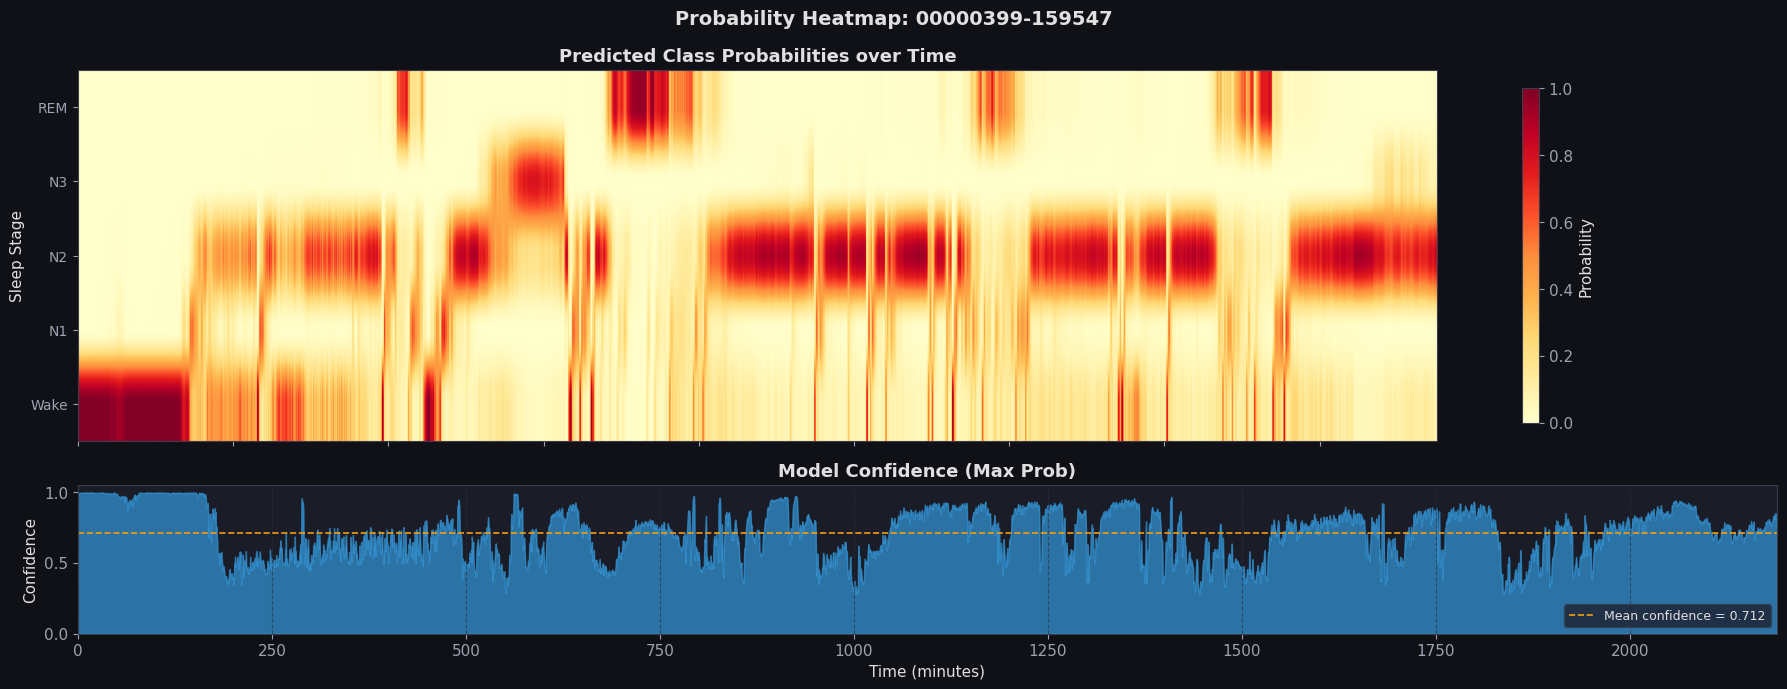

💾 Saved: prob_heatmap_00000399-159547.png


In [8]:
# ─── Probability Heatmap ──────────────────────────────────────────────────────

def plot_prob_heatmap(df, subject_id):
    prob_matrix = df[PROB_COLS].values.T   # shape (5, n_epochs)
    t = df['time_min'].values

    fig, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=True,
                             gridspec_kw={'height_ratios': [3, 1.2]})
    fig.suptitle(f'Probability Heatmap: {subject_id}', fontsize=14, fontweight='bold')

    im = axes[0].imshow(
        prob_matrix, aspect='auto', origin='lower',
        extent=[t[0], t[-1], -0.5, 4.5],
        cmap='YlOrRd', vmin=0, vmax=1
    )
    axes[0].set_yticks(range(5))
    axes[0].set_yticklabels(STAGE_ORDER, fontsize=10)
    axes[0].set_ylabel('Sleep Stage')
    axes[0].set_title('Predicted Class Probabilities over Time')
    plt.colorbar(im, ax=axes[0], label='Probability', shrink=0.9)

    # Max probability (confidence) over time
    max_prob = df[PROB_COLS].max(axis=1).values
    axes[1].fill_between(t, max_prob, 0, color='#3498DB', alpha=0.7)
    axes[1].axhline(max_prob.mean(), color='#F39C12', linestyle='--',
                    linewidth=1.2, label=f'Mean confidence = {max_prob.mean():.3f}')
    axes[1].set_ylim(0, 1.05)
    axes[1].set_xlabel('Time (minutes)')
    axes[1].set_ylabel('Confidence')
    axes[1].set_title('Model Confidence (Max Prob)')
    axes[1].legend(loc='lower right', fontsize=9)
    axes[1].grid(axis='x')

    plt.tight_layout()
    fname = f'prob_heatmap_{subject_id}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'💾 Saved: {fname}')

plot_prob_heatmap(example_df, example_id)

---
## 6. Per-Subject Metrics Summary

In [9]:
# ─── Per-Subject Metrics ──────────────────────────────────────────────────────

rows = []
for df in all_dfs:
    sid      = df['subject_id'].iloc[0]
    yt       = df['true_stage'].values
    yp       = df['predicted_stage'].values
    ps       = sorted(df['true_stage'].unique())
    n_epochs = len(df)
    acc_s    = accuracy_score(yt, yp)
    f1_m     = f1_score(yt, yp, average='macro',    labels=ps, zero_division=0)
    f1_w     = f1_score(yt, yp, average='weighted', labels=ps, zero_division=0)
    kap      = cohen_kappa_score(yt, yp)
    conf_mean = df[PROB_COLS].max(axis=1).mean()
    rows.append({
        'Subject':       sid,
        'N_Epochs':      n_epochs,
        'Accuracy':      acc_s,
        'Macro_F1':      f1_m,
        'Weighted_F1':   f1_w,
        'Cohen_Kappa':   kap,
        'Avg_Confidence':conf_mean,
    })

per_sub_df = pd.DataFrame(rows).sort_values('Macro_F1', ascending=False)
print(per_sub_df.to_string(index=False, float_format='{:.4f}'.format))

        Subject  N_Epochs  Accuracy  Macro_F1  Weighted_F1  Cohen_Kappa  Avg_Confidence
00000413-159547      4800    0.8758    0.8611       0.8748       0.8305          0.8009
00000452-159547      5520    0.8004    0.7916       0.7926       0.7215          0.7960
00000443-159547      5040    0.8312    0.7715       0.8483       0.7665          0.7276
00000449-159547      4860    0.7467    0.7048       0.7223       0.6387          0.7727
00000401-159547      5040    0.7972    0.6726       0.7934       0.6896          0.7718
00000446-159547      4980    0.7510    0.6691       0.7678       0.6685          0.7186
00000399-159547      4380    0.7470    0.6672       0.7355       0.6156          0.7116
00000422-159547      4620    0.7229    0.6630       0.7101       0.6079          0.7126
00000409-159547      4800    0.7023    0.6565       0.6790       0.6057          0.7069
00000425-159547      5520    0.7100    0.6439       0.6914       0.5496          0.7313
00000405-159547      4818    0.7

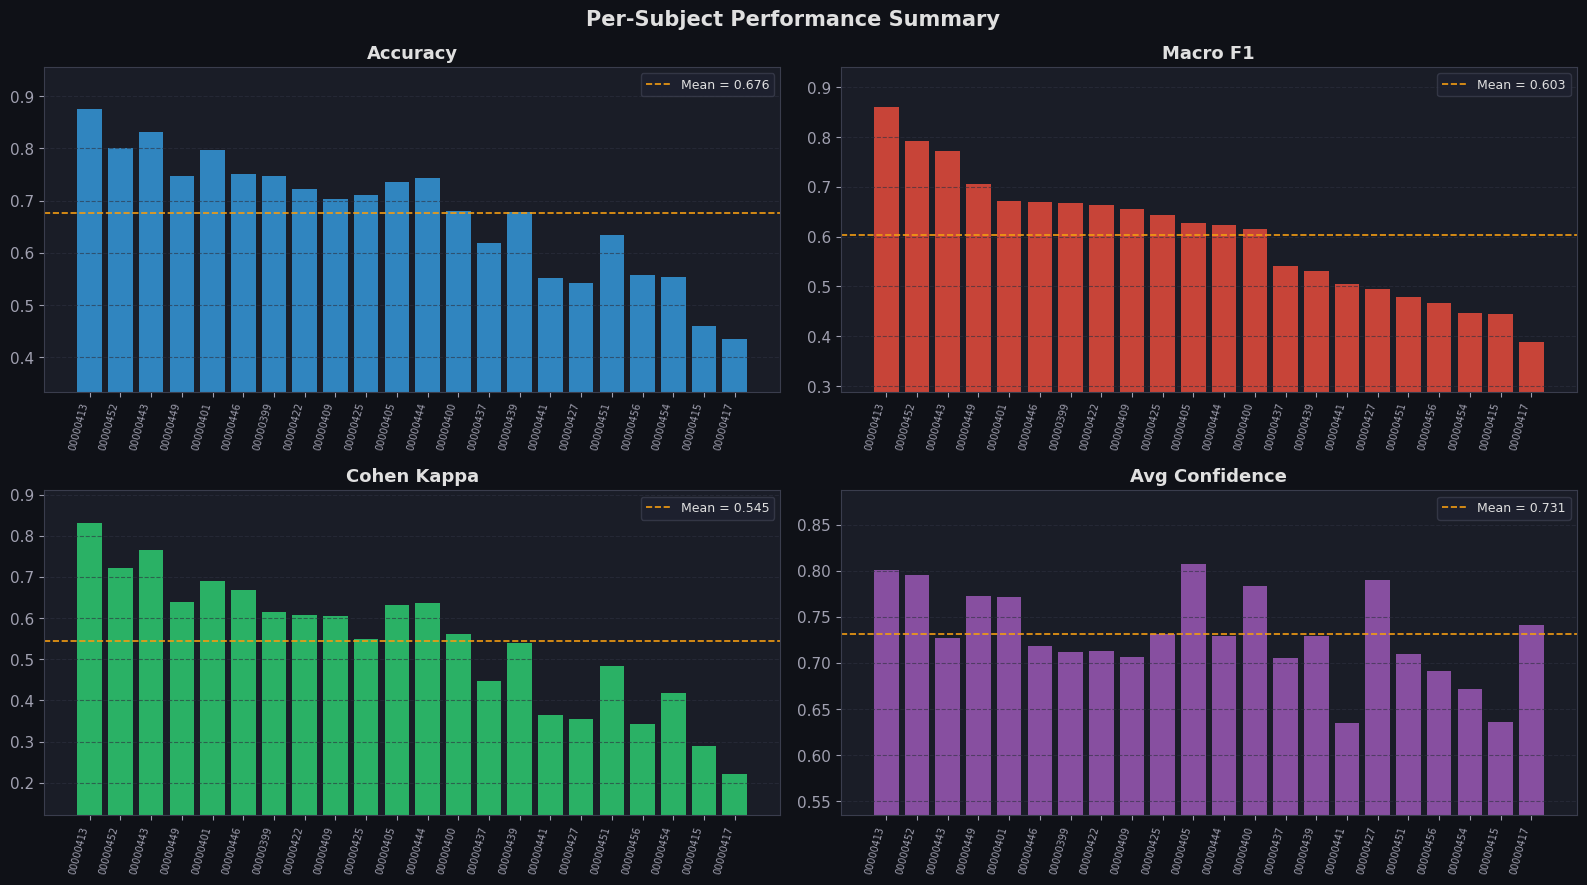

💾 Saved: per_subject_metrics.png


In [10]:
# ─── Per-Subject Metrics (Visual) ─────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.suptitle('Per-Subject Performance Summary', fontsize=15, fontweight='bold')

metrics_plot = [
    ('Accuracy',      '#3498DB', axes[0,0]),
    ('Macro_F1',      '#E74C3C', axes[0,1]),
    ('Cohen_Kappa',   '#2ECC71', axes[1,0]),
    ('Avg_Confidence','#9B59B6', axes[1,1]),
]

short_ids = [s.split('-')[0] for s in per_sub_df['Subject']]

for metric, color, ax in metrics_plot:
    vals = per_sub_df[metric].values
    bars = ax.bar(range(len(vals)), vals, color=color, alpha=0.85)
    ax.set_xticks(range(len(vals)))
    ax.set_xticklabels(short_ids, rotation=75, ha='right', fontsize=7)
    ax.set_ylim(max(0, vals.min() - 0.1), min(1.05, vals.max() + 0.08))
    mean_val = vals.mean()
    ax.axhline(mean_val, color='#F39C12', linestyle='--', linewidth=1.2,
               label=f'Mean = {mean_val:.3f}')
    ax.set_title(metric.replace('_', ' '))
    ax.legend(fontsize=9)
    ax.grid(axis='y')

plt.tight_layout()
plt.savefig('per_subject_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: per_subject_metrics.png')

---
## 7. Sleep Stage Distribution — True vs Predicted

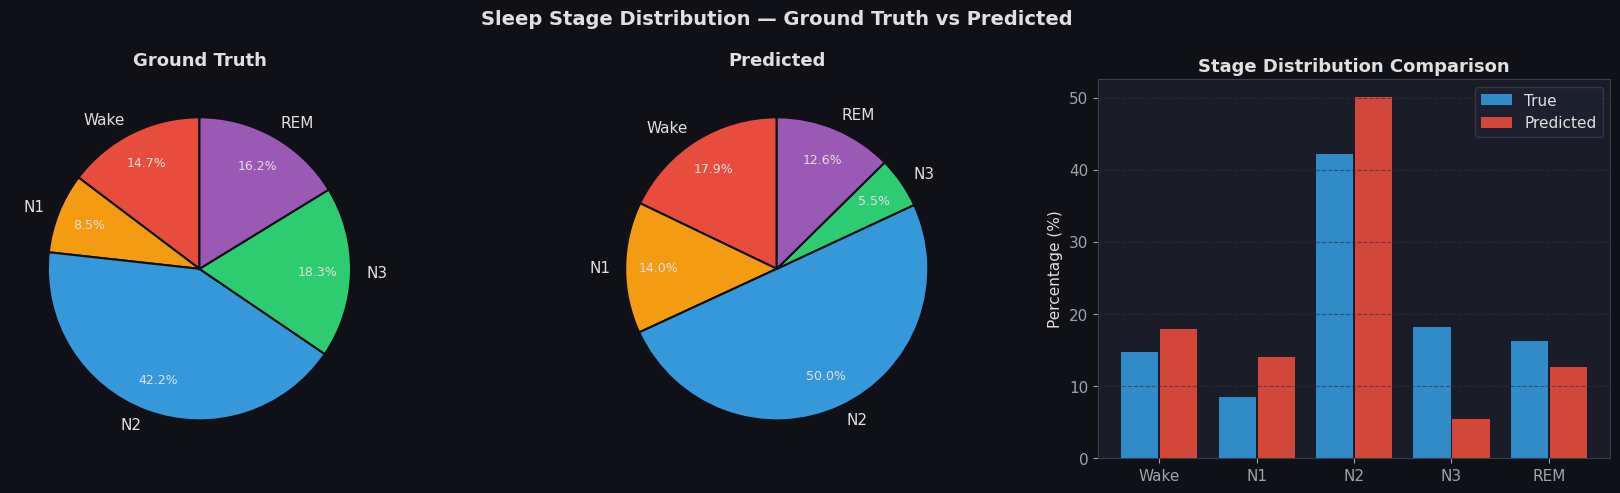

💾 Saved: stage_distribution.png


In [11]:
# ─── Stage Distribution Comparison ───────────────────────────────────────────

true_dist = combined_df['true_stage'].value_counts().sort_index()
pred_dist = combined_df['predicted_stage'].value_counts().sort_index()

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Sleep Stage Distribution — Ground Truth vs Predicted', fontsize=14, fontweight='bold')

# Pie charts
for ax, dist, title in [
    (axes[0], true_dist, 'Ground Truth'),
    (axes[1], pred_dist, 'Predicted'),
]:
    labels_pie = [STAGE_NAMES[i] for i in dist.index]
    colors_pie = [STAGE_COLORS[STAGE_NAMES[i]] for i in dist.index]
    wedges, texts, autotexts = ax.pie(
        dist.values, labels=labels_pie, colors=colors_pie,
        autopct='%1.1f%%', startangle=90,
        pctdistance=0.78,
        wedgeprops={'edgecolor': '#0F1117', 'linewidth': 1.5}
    )
    for at in autotexts:
        at.set_fontsize(9)
    ax.set_title(title, pad=10)

# Side-by-side bar chart
ax = axes[2]
all_stages = sorted(set(true_dist.index) | set(pred_dist.index))
x = np.arange(len(all_stages))
true_vals  = [true_dist.get(s, 0) for s in all_stages]
pred_vals  = [pred_dist.get(s, 0) for s in all_stages]
total      = sum(true_vals)

ax.bar(x - 0.2, [100*v/total for v in true_vals], 0.38,
       label='True',      color='#3498DB', alpha=0.9)
ax.bar(x + 0.2, [100*v/total for v in pred_vals], 0.38,
       label='Predicted', color='#E74C3C', alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels([STAGE_NAMES[s] for s in all_stages], fontsize=11)
ax.set_ylabel('Percentage (%)')
ax.set_title('Stage Distribution Comparison')
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.savefig('stage_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: stage_distribution.png')

---
## 8. Probability Distribution per Stage (Violin / Box Plot)

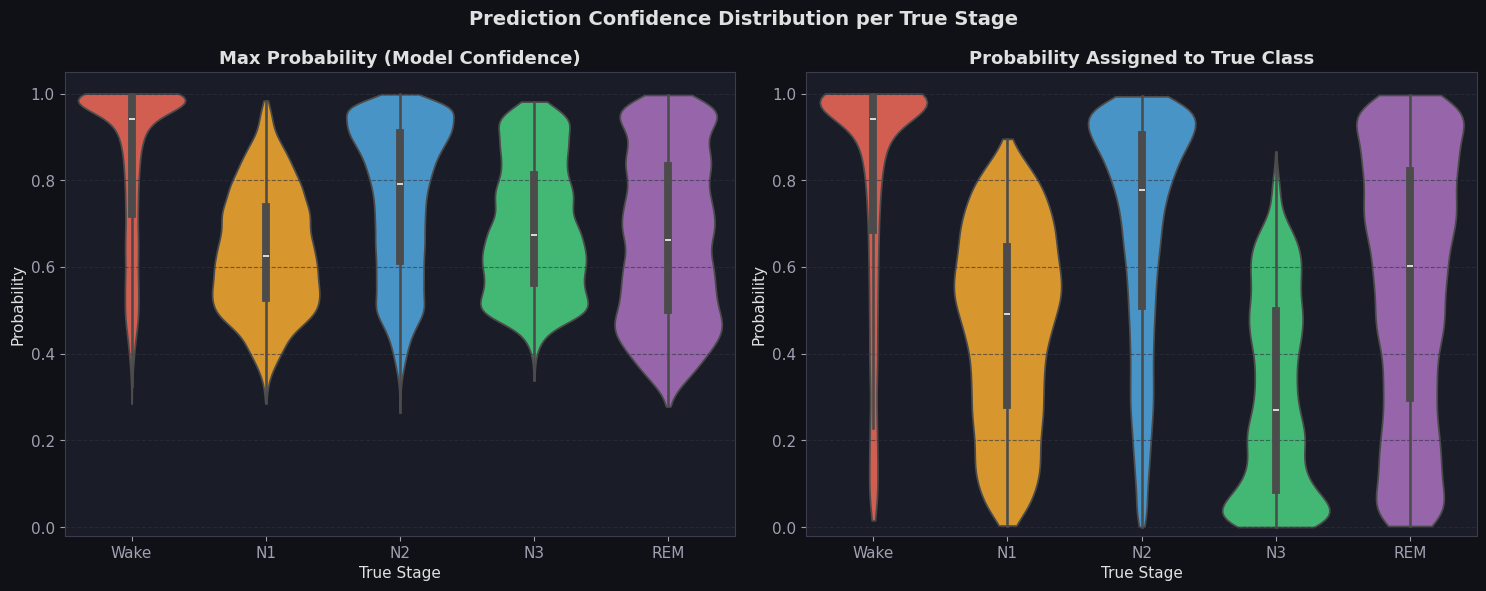

💾 Saved: probability_violin.png


In [12]:
# ─── Softmax Probability Distribution per True Stage ─────────────────────────

prob_stage_data = []
for s in present_stages:
    sub = combined_df[combined_df['true_stage'] == s]
    max_prob = sub[PROB_COLS].max(axis=1).values
    correct_prob = sub[PROB_COLS].iloc[:, s].values  # prob of the true class
    for v, c in zip(max_prob, correct_prob):
        prob_stage_data.append({'Stage': STAGE_NAMES[s], 'Max_Prob': v, 'True_Class_Prob': c})

prob_stage_df = pd.DataFrame(prob_stage_data)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Prediction Confidence Distribution per True Stage', fontsize=14, fontweight='bold')

palette = {s: STAGE_COLORS[s] for s in STAGE_ORDER if s in prob_stage_df['Stage'].unique()}

for ax, col, title in [
    (axes[0], 'Max_Prob',       'Max Probability (Model Confidence)'),
    (axes[1], 'True_Class_Prob', 'Probability Assigned to True Class'),
]:
    sns.violinplot(
        data=prob_stage_df, x='Stage', y=col,
        order=[s for s in STAGE_ORDER if s in prob_stage_df['Stage'].unique()],
        palette=palette, ax=ax, inner='box', cut=0
    )
    ax.set_xlabel('True Stage')
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.set_ylim(-0.02, 1.05)
    ax.grid(axis='y')

plt.tight_layout()
plt.savefig('probability_violin.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: probability_violin.png')

---
## 9. Transition Matrix — Stage Transitions

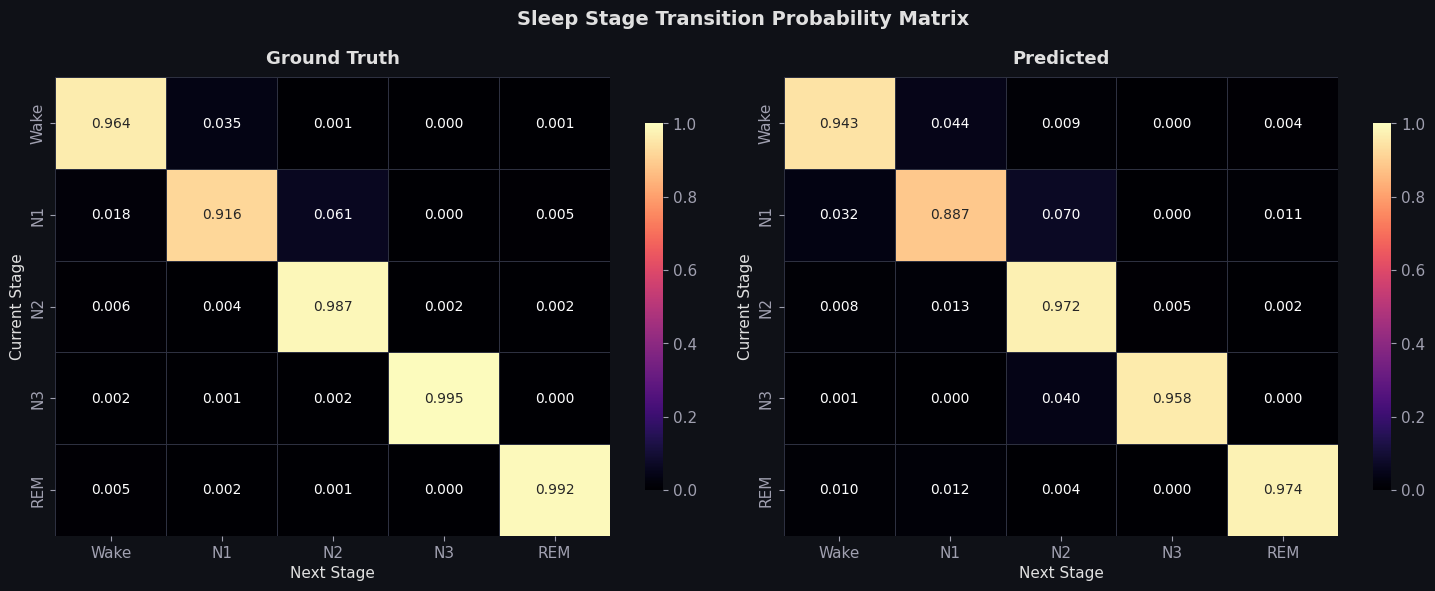

💾 Saved: transition_matrix.png


In [13]:
# ─── Stage-Transition Matrix (True vs Predicted) ──────────────────────────────

def compute_transition_matrix(stages, n_stages=5):
    """Count epoch-to-epoch transitions."""
    tm = np.zeros((n_stages, n_stages), dtype=int)
    for a, b in zip(stages[:-1], stages[1:]):
        if 0 <= a < n_stages and 0 <= b < n_stages:
            tm[a, b] += 1
    return tm

n_stages_total = max(present_stages) + 1
names_all = [STAGE_NAMES[i] for i in range(n_stages_total)]

# Aggregate across all subjects
tm_true = np.zeros((n_stages_total, n_stages_total), dtype=int)
tm_pred = np.zeros((n_stages_total, n_stages_total), dtype=int)
for df in all_dfs:
    tm_true += compute_transition_matrix(df['true_stage'].values, n_stages_total)
    tm_pred += compute_transition_matrix(df['predicted_stage'].values, n_stages_total)

# Row-normalize
def row_norm(tm):
    row_sums = tm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    return tm / row_sums

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Sleep Stage Transition Probability Matrix', fontsize=14, fontweight='bold')

for ax, tm, title in [
    (axes[0], row_norm(tm_true), 'Ground Truth'),
    (axes[1], row_norm(tm_pred), 'Predicted'),
]:
    mask = tm == 0
    sns.heatmap(
        tm, ax=ax, annot=True, fmt='.3f', cmap='magma',
        xticklabels=names_all, yticklabels=names_all,
        linewidths=0.5, linecolor='#2D3040', vmin=0, vmax=1,
        cbar_kws={'shrink': 0.8},
        annot_kws={'size': 10}
    )
    ax.set_title(title, pad=10)
    ax.set_xlabel('Next Stage')
    ax.set_ylabel('Current Stage')

plt.tight_layout()
plt.savefig('transition_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: transition_matrix.png')

---
## 10. Error Analysis — Epoch-Level Accuracy over Sleep Night

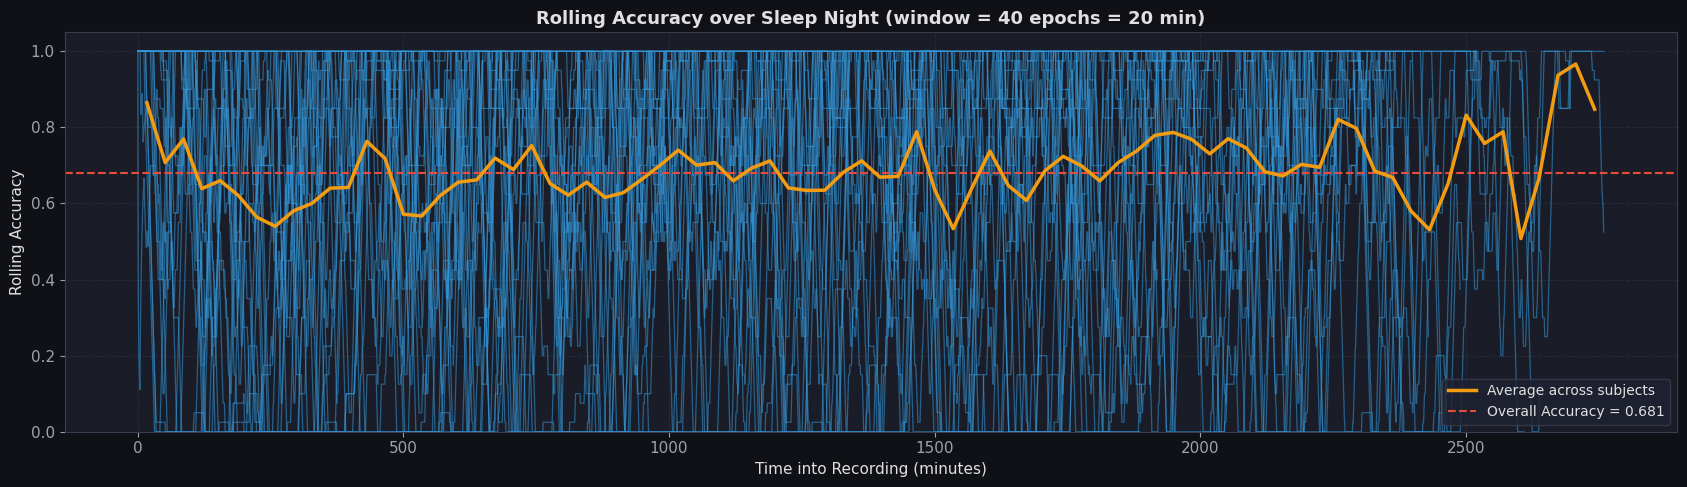

💾 Saved: rolling_accuracy.png


In [14]:
# ─── Rolling Accuracy over the Night ─────────────────────────────────────────

WINDOW = 40   # rolling window in epochs (~20 min)

fig, ax = plt.subplots(figsize=(17, 5))

for df in all_dfs:
    correct = (df['predicted_stage'] == df['true_stage']).astype(float)
    rolling_acc = correct.rolling(window=WINDOW, min_periods=1).mean()
    ax.plot(df['time_min'], rolling_acc,
            linewidth=0.9, alpha=0.55, color='#3498DB')

# Overall average
combined_df_sorted = combined_df.sort_values(['subject_id', 'epoch_idx'])
# Bin by quantile of time to get average accuracy curve
combined_df['time_bin'] = pd.cut(combined_df['time_min'], bins=80, labels=False)
avg_acc = combined_df.groupby('time_bin').apply(
    lambda x: accuracy_score(x['true_stage'], x['predicted_stage'])
).reset_index()
time_centers = combined_df.groupby('time_bin')['time_min'].mean().values

ax.plot(time_centers, avg_acc[0].values, color='#F39C12', linewidth=2.5,
        label='Average across subjects', zorder=5)
ax.axhline(acc, color='#E74C3C', linestyle='--', linewidth=1.5,
           label=f'Overall Accuracy = {acc:.3f}')

ax.set_xlabel('Time into Recording (minutes)')
ax.set_ylabel('Rolling Accuracy')
ax.set_title(f'Rolling Accuracy over Sleep Night (window = {WINDOW} epochs = {WINDOW*EPOCH_SEC/60:.0f} min)')
ax.set_ylim(0, 1.05)
ax.legend(fontsize=10)
ax.grid()

plt.tight_layout()
plt.savefig('rolling_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: rolling_accuracy.png')

---
## 11. All Subjects — Hypnogram Gallery (Grid)

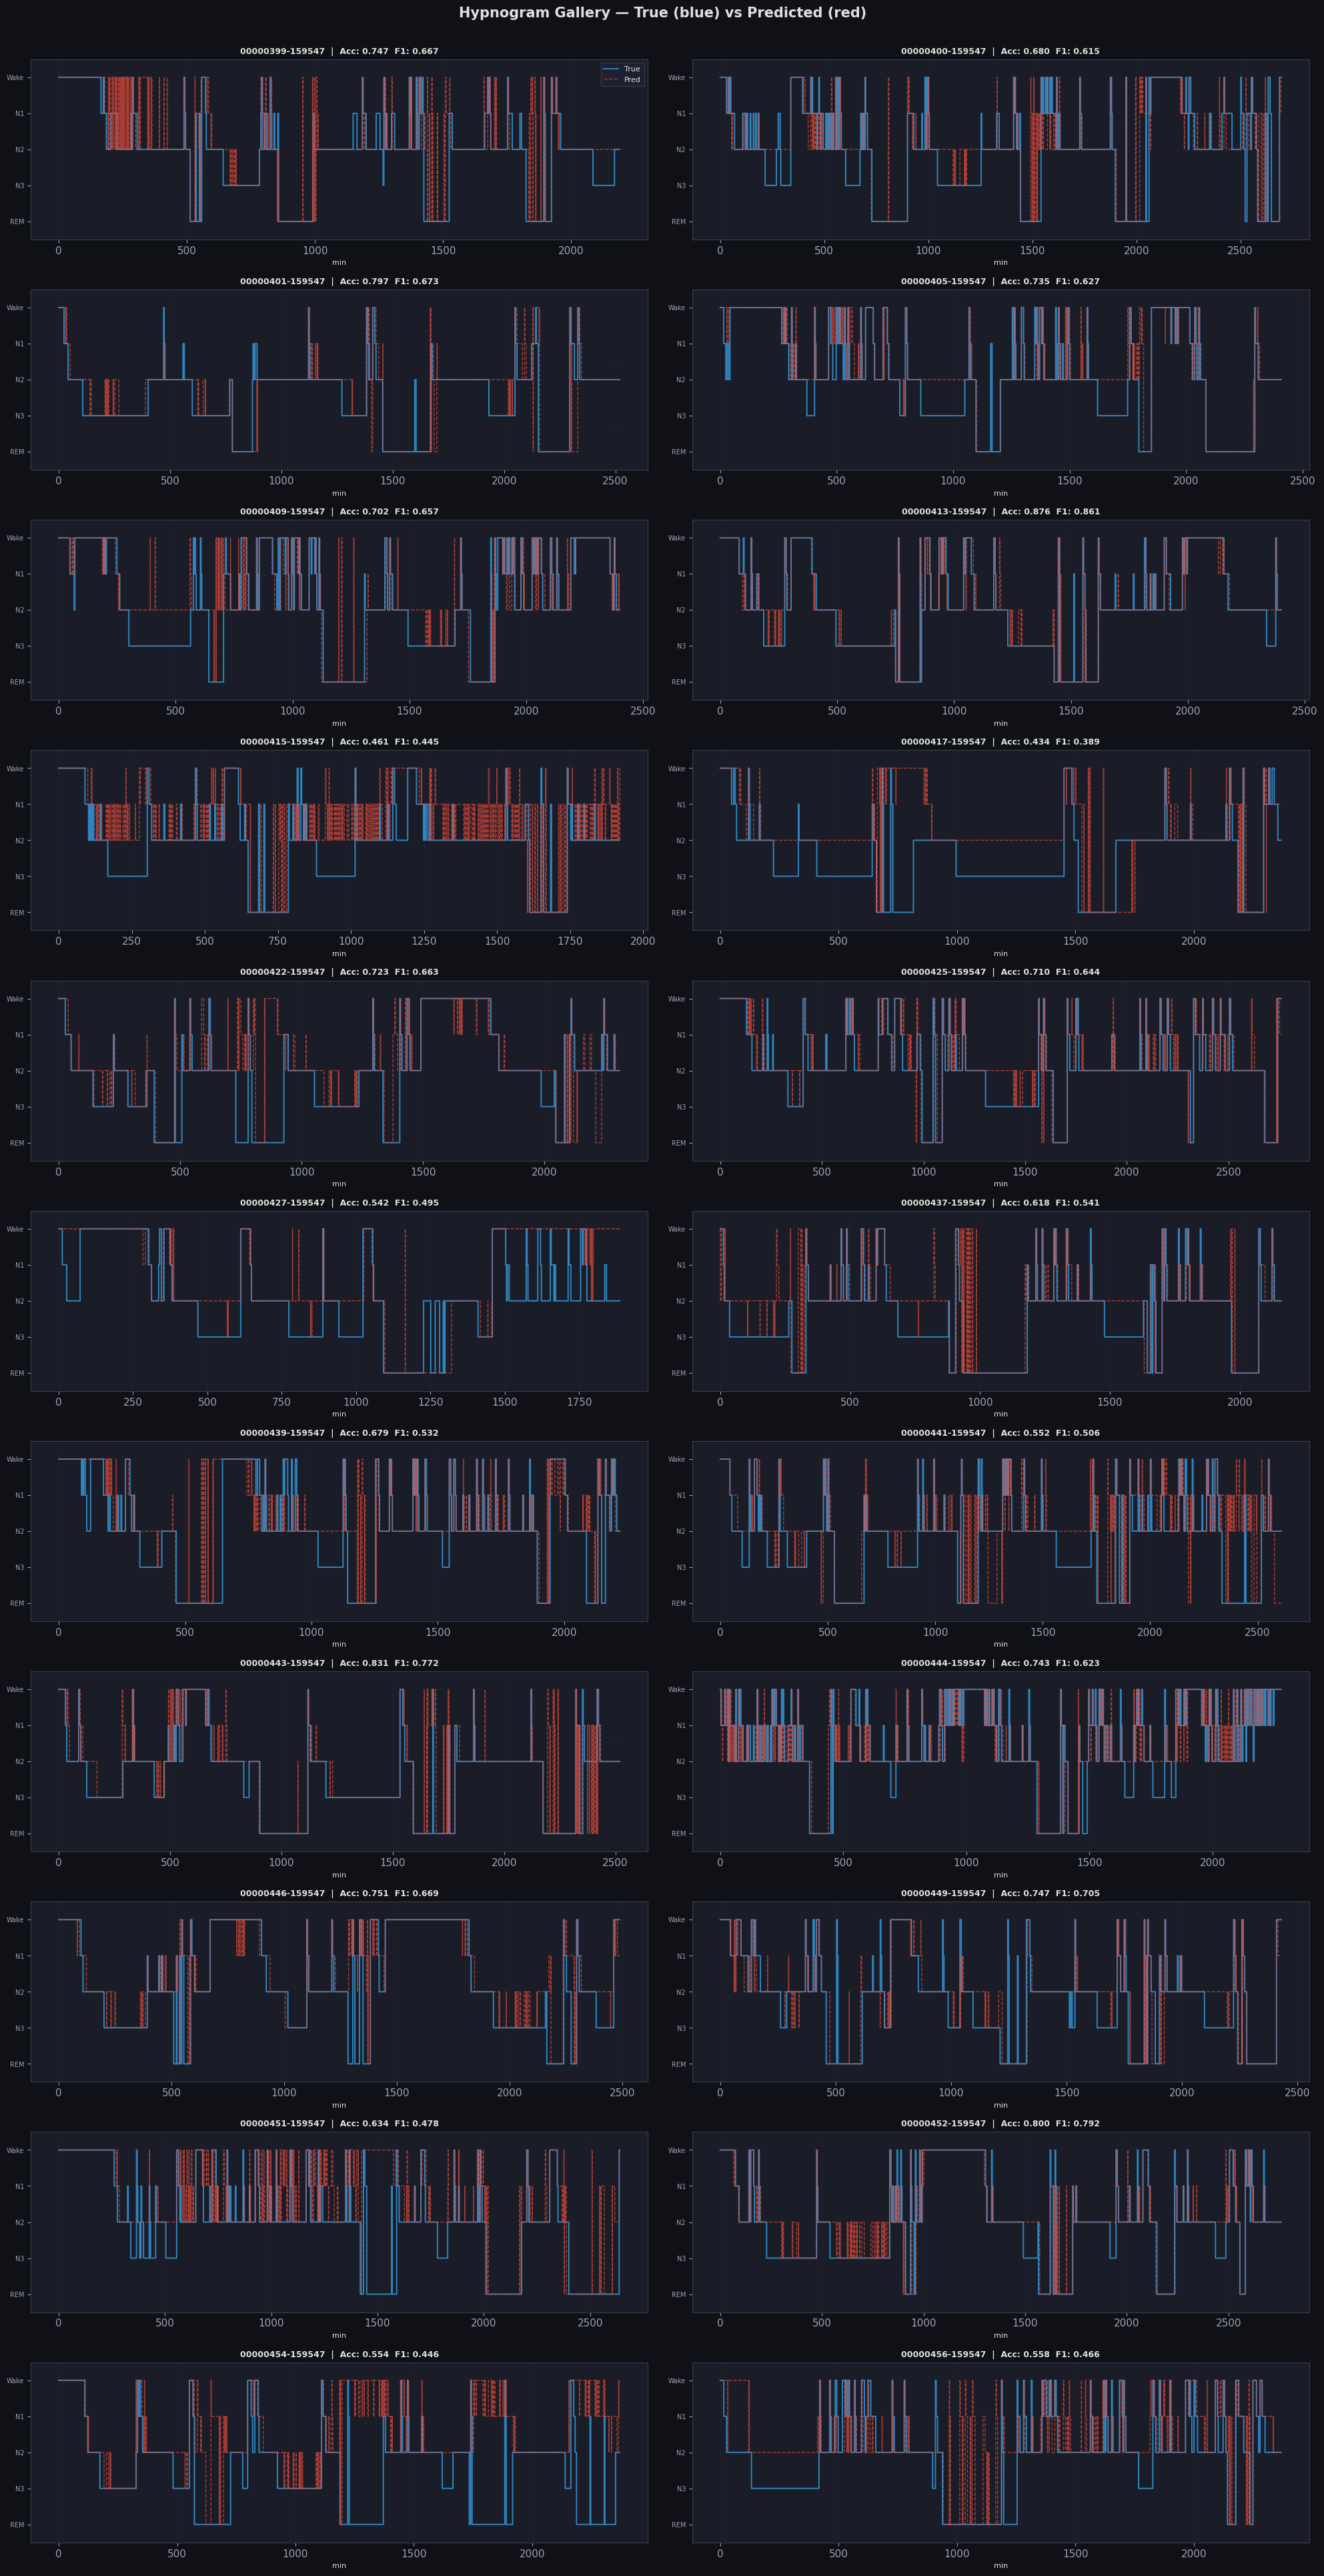

💾 Saved: hypnogram_gallery.png


In [15]:
# ─── Compact Hypnogram Gallery ────────────────────────────────────────────────

n_subjects = len(all_dfs)
ncols = 2
nrows = (n_subjects + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 3.5 * nrows))
fig.suptitle('Hypnogram Gallery — True (blue) vs Predicted (red)', fontsize=15, fontweight='bold', y=1.002)

stage_y_map = {0: 4, 1: 3, 2: 2, 3: 1, 4: 0}
axes_flat = axes.flatten() if n_subjects > 1 else [axes]

for i, df in enumerate(all_dfs):
    ax = axes_flat[i]
    t  = df['time_min'].values
    true_y = [stage_y_map[s] for s in df['true_stage'].values]
    pred_y = [stage_y_map[s] for s in df['predicted_stage'].values]

    ax.step(t, true_y, where='post', color='#3498DB', linewidth=1.4, alpha=0.85, label='True')
    ax.step(t, pred_y, where='post', color='#E74C3C', linewidth=1.0, alpha=0.7,  label='Pred', linestyle='--')

    sid = df['subject_id'].iloc[0]
    subj_acc = accuracy_score(df['true_stage'], df['predicted_stage'])
    subj_f1  = f1_score(df['true_stage'], df['predicted_stage'],
                        average='macro', labels=sorted(df['true_stage'].unique()), zero_division=0)

    ax.set_title(f'{sid}  |  Acc: {subj_acc:.3f}  F1: {subj_f1:.3f}', fontsize=9)
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(['REM', 'N3', 'N2', 'N1', 'Wake'], fontsize=7)
    ax.set_ylim(-0.5, 4.5)
    ax.set_xlabel('min', fontsize=8)
    ax.grid(axis='x', alpha=0.4)
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)

# Hide unused axes
for j in range(i+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.savefig('hypnogram_gallery.png', dpi=120, bbox_inches='tight')
plt.show()
print('💾 Saved: hypnogram_gallery.png')

---
## 12. Summary Dashboard

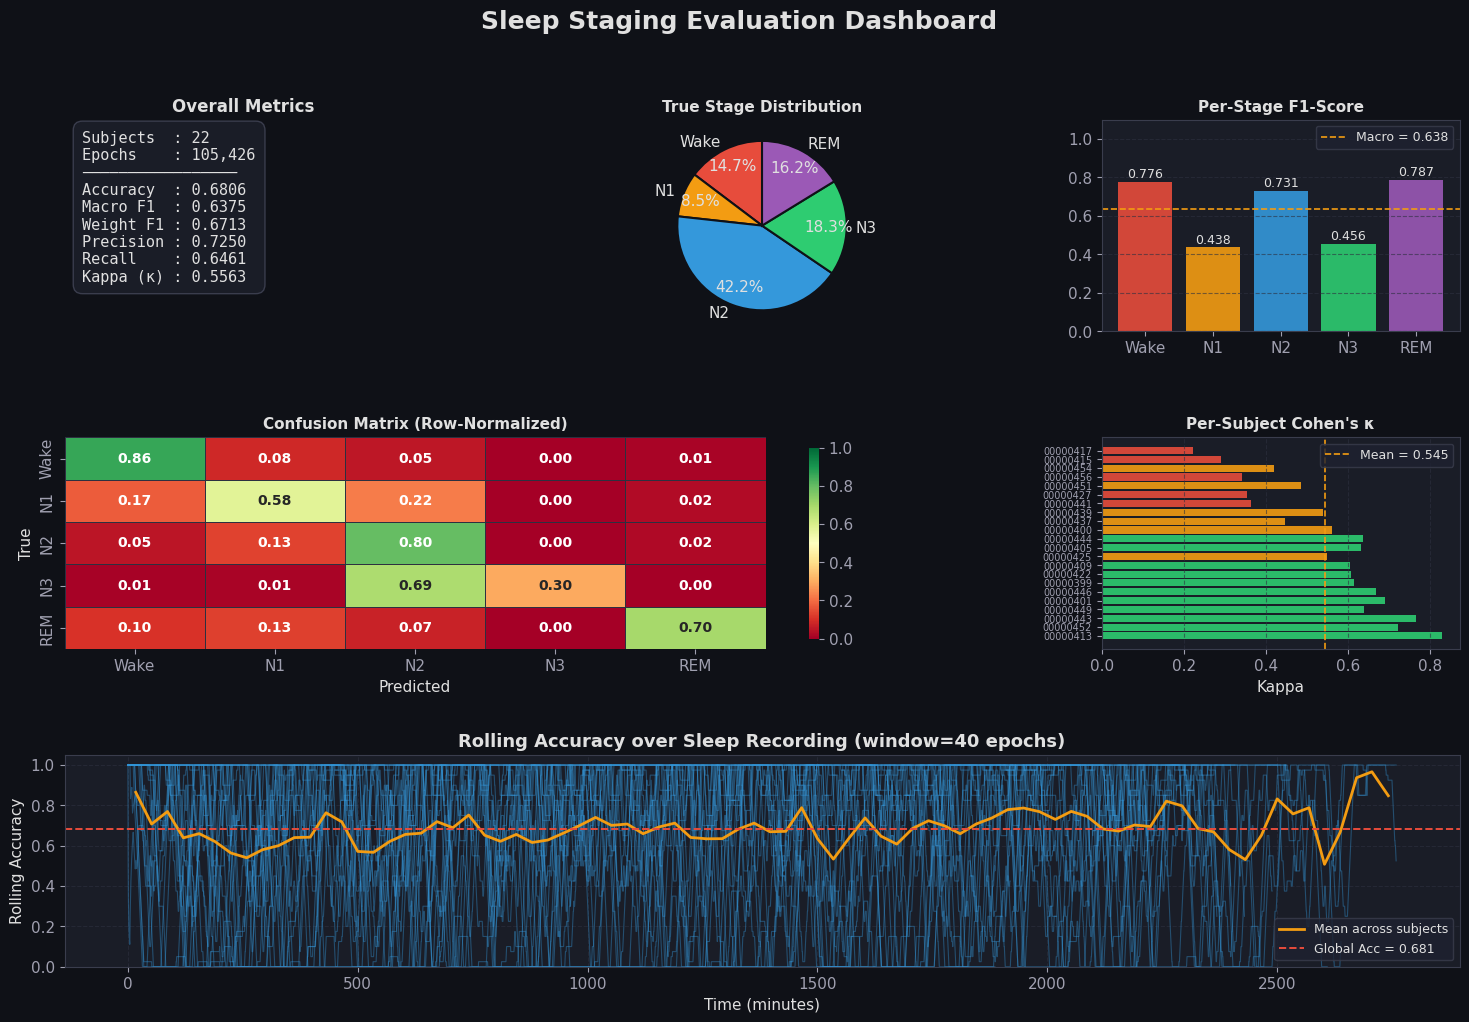

💾 Saved: summary_dashboard.png


In [16]:
# ─── Summary Dashboard ────────────────────────────────────────────────────────

fig = plt.figure(figsize=(18, 11))
fig.patch.set_facecolor('#0F1117')
fig.suptitle('Sleep Staging Evaluation Dashboard', fontsize=18, fontweight='bold', y=0.98)

gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.45)

# ── [0,0] : Global metrics text box
ax_txt = fig.add_subplot(gs[0, 0])
ax_txt.axis('off')
metrics_text = (
    f"Subjects  : {len(all_dfs)}\n"
    f"Epochs    : {len(combined_df):,}\n"
    f"─────────────────\n"
    f"Accuracy  : {acc:.4f}\n"
    f"Macro F1  : {f1_macro:.4f}\n"
    f"Weight F1 : {f1_weighted:.4f}\n"
    f"Precision : {prec:.4f}\n"
    f"Recall    : {rec:.4f}\n"
    f"Kappa (κ) : {kappa:.4f}"
)
ax_txt.text(0.05, 0.95, metrics_text, transform=ax_txt.transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            color='#E0E0E0',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='#1A1D27', edgecolor='#3A3D4D'))
ax_txt.set_title('Overall Metrics', fontsize=12, pad=6)

# ── [0,1] : True distribution pie
ax_pie = fig.add_subplot(gs[0, 1])
labels_pie = [STAGE_NAMES[i] for i in true_dist.index]
colors_pie  = [STAGE_COLORS[STAGE_NAMES[i]] for i in true_dist.index]
ax_pie.pie(true_dist.values, labels=labels_pie, colors=colors_pie,
           autopct='%1.1f%%', startangle=90, pctdistance=0.78,
           wedgeprops={'edgecolor': '#0F1117', 'linewidth': 1.5})
ax_pie.set_title('True Stage Distribution', fontsize=11)

# ── [0,2] : Per-stage F1
ax_f1 = fig.add_subplot(gs[0, 2])
colors_bar = [STAGE_COLORS[n] for n in target_names]
ax_f1.bar(target_names, f1_per, color=colors_bar, alpha=0.9)
ax_f1.axhline(f1_macro, color='#F39C12', linestyle='--', linewidth=1.2,
              label=f'Macro = {f1_macro:.3f}')
ax_f1.set_ylim(0, 1.1)
ax_f1.set_title('Per-Stage F1-Score', fontsize=11)
ax_f1.legend(fontsize=9)
ax_f1.grid(axis='y')
for bar, v in zip(ax_f1.patches, f1_per):
    ax_f1.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.3f}',
               ha='center', fontsize=9)

# ── [1, 0:2] : Normalized confusion matrix
ax_cm = fig.add_subplot(gs[1, 0:2])
sns.heatmap(cm_norm, ax=ax_cm, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=target_names, yticklabels=target_names,
            linewidths=0.5, linecolor='#2D3040',
            vmin=0, vmax=1, cbar_kws={'shrink': 0.9},
            annot_kws={'size': 10, 'weight': 'bold'})
ax_cm.set_title('Confusion Matrix (Row-Normalized)', fontsize=11)
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('True')

# ── [1, 2] : Per-subject kappa
ax_kap = fig.add_subplot(gs[1, 2])
kappas = per_sub_df['Cohen_Kappa'].values
short  = [s.split('-')[0] for s in per_sub_df['Subject']]
bar_colors_kap = ['#2ECC71' if k >= 0.6 else '#F39C12' if k >= 0.4 else '#E74C3C' for k in kappas]
ax_kap.barh(range(len(kappas)), kappas, color=bar_colors_kap, alpha=0.9)
ax_kap.set_yticks(range(len(kappas)))
ax_kap.set_yticklabels(short, fontsize=7)
ax_kap.axvline(kappas.mean(), color='#F39C12', linestyle='--', linewidth=1.2,
               label=f'Mean = {kappas.mean():.3f}')
ax_kap.set_title("Per-Subject Cohen's κ", fontsize=11)
ax_kap.legend(fontsize=9)
ax_kap.set_xlabel('Kappa')
ax_kap.grid(axis='x')

# ── [2, :] : Rolling accuracy
ax_roll = fig.add_subplot(gs[2, :])
for df in all_dfs:
    correct  = (df['predicted_stage'] == df['true_stage']).astype(float)
    roll_acc = correct.rolling(window=WINDOW, min_periods=1).mean()
    ax_roll.plot(df['time_min'], roll_acc, linewidth=0.8, alpha=0.4, color='#3498DB')
ax_roll.plot(time_centers, avg_acc[0].values, color='#F39C12', linewidth=2.0,
            label='Mean across subjects')
ax_roll.axhline(acc, color='#E74C3C', linestyle='--', linewidth=1.4,
               label=f'Global Acc = {acc:.3f}')
ax_roll.set_ylim(0, 1.05)
ax_roll.set_xlabel('Time (minutes)')
ax_roll.set_ylabel('Rolling Accuracy')
ax_roll.set_title(f'Rolling Accuracy over Sleep Recording (window={WINDOW} epochs)')
ax_roll.legend(fontsize=9, loc='lower right')
ax_roll.grid()

plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved: summary_dashboard.png')

---
## 13. Export Metrics to CSV

In [17]:
# ─── Export ───────────────────────────────────────────────────────────────────

per_sub_df.to_csv('per_subject_metrics.csv', index=False)
metrics_df.to_csv('per_stage_metrics.csv',   index=False)

global_metrics = pd.DataFrame([{
    'Accuracy':    acc,
    'Macro_F1':    f1_macro,
    'Weighted_F1': f1_weighted,
    'Precision':   prec,
    'Recall':      rec,
    'Cohen_Kappa': kappa,
    'N_Subjects':  len(all_dfs),
    'N_Epochs':    len(combined_df),
}])
global_metrics.to_csv('global_metrics.csv', index=False)

print('✅ Exported:')
print('   per_subject_metrics.csv')
print('   per_stage_metrics.csv')
print('   global_metrics.csv')
print('\n🎉  All done!')

✅ Exported:
   per_subject_metrics.csv
   per_stage_metrics.csv
   global_metrics.csv

🎉  All done!
